In [2]:
from pyspark.sql import SparkSession

#start session 
spark_session = SparkSession.builder.appName("VCF_test")\
.config ("spark.sql.shuffle.partitions", "50")\
.config("spark.driver.maxResultSize","5g")\
.config ("spark.sql.execution.arrow.enabled", "true")\
.getOrCreate()

spark_context = spark_session.sparkContext

In [3]:
vcf = spark_context.textFile("File:///home/ubuntu/test.vcf")
vcf.take(20)

['t=VCFv4.0',
 '##fileDate=20090805',
 '##source=myImputationProgramV3.1',
 '##reference=1000GenomesPilot-NCBI36',
 '##phasing=partial',
 '##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">',
 '##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">',
 '##INFO=<ID=AF,Number=.,Type=Float,Description="Allele Frequency">',
 '##INFO=<ID=AA,Number=1,Type=String,Description="Ancestral Allele">',
 '##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">',
 '##INFO=<ID=H2,Number=0,Type=Flag,Description="HapMap2 membership">',
 '##FILTER=<ID=q10,Description="Quality below 10">',
 '##FILTER=<ID=s50,Description="Less than 50% of samples have data">',
 '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">',
 '##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">',
 '##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">',
 '##FORMAT=<ID=HQ,Number=2,Type=Integer,Description="Haplotype Quality">',
 '#CHROM POS   

In [4]:
#remove rows that start with ## 
vcf = vcf.filter(lambda line : not  line.startswith('t=VCF'))\
    .filter(lambda line : not line.startswith('##'))\
    .map(lambda line : line.split())
vcf.take(20)

[['#CHROM',
  'POS',
  'ID',
  'REF',
  'ALT',
  'QUAL',
  'FILTER',
  'INFO',
  'FORMAT',
  'NA00001',
  'NA00002',
  'NA00003'],
 ['20',
  '14370',
  'rs6054257',
  'G',
  'A',
  '29',
  'PASS',
  'NS=3;DP=14;AF=0.5;DB;H2',
  'GT:GQ:DP:HQ',
  '0|0:48:1:51,51',
  '1|0:48:8:51,51',
  '1/1:43:5:.,.'],
 ['20',
  '17330',
  '.',
  'T',
  'A',
  '3',
  'q10',
  'NS=3;DP=11;AF=0.017',
  'GT:GQ:DP:HQ',
  '0|0:49:3:58,50',
  '0|1:3:5:65,3',
  '0/0:41:3'],
 ['20',
  '1110696',
  'rs6040355',
  'A',
  'G,T',
  '67',
  'PASS',
  'NS=2;DP=10;AF=0.333,0.667;AA=T;DB',
  'GT:GQ:DP:HQ',
  '1|2:21:6:23,27',
  '2|1:2:0:18,2',
  '2/2:35:4'],
 ['20',
  '1230237',
  '.',
  'T',
  '.',
  '47',
  'PASS',
  'NS=3;DP=13;AA=T',
  'GT:GQ:DP:HQ',
  '0|0:54:7:56,60',
  '0|0:48:4:51,51',
  '0/0:61:2'],
 ['20',
  '1234567',
  'microsat1',
  'GTCT',
  'G,GTACT',
  '50',
  'PASS',
  'NS=3;DP=9;AA=G',
  'GT:GQ:DP',
  '0/1:35:4',
  '0/2:17:2',
  '1/1:40:3']]

In [5]:
#create df with header 
vcf = vcf.toDF(schema = vcf.first()) 
vcf = vcf.filter(vcf["#CHROM"]!="#CHROM")
vcf.show()

+------+-------+---------+----+-------+----+------+--------------------+-----------+--------------+--------------+------------+
|#CHROM|    POS|       ID| REF|    ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|
+------+-------+---------+----+-------+----+------+--------------------+-----------+--------------+--------------+------------+
|    20|  14370|rs6054257|   G|      A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|
|    20|  17330|        .|   T|      A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|
|    20|1110696|rs6040355|   A|    G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|
|    20|1230237|        .|   T|      .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|
|    20|1234567|microsat1|GTCT|G,GTACT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|      0/1:35:4|     

In [6]:
from pyspark.sql.types import *

#Make POS integer
vcf = vcf.withColumn("POS", vcf["POS"].cast(IntegerType()))
vcf.printSchema()

root
 |-- #CHROM: string (nullable = true)
 |-- POS: integer (nullable = true)
 |-- ID: string (nullable = true)
 |-- REF: string (nullable = true)
 |-- ALT: string (nullable = true)
 |-- QUAL: string (nullable = true)
 |-- FILTER: string (nullable = true)
 |-- INFO: string (nullable = true)
 |-- FORMAT: string (nullable = true)
 |-- NA00001: string (nullable = true)
 |-- NA00002: string (nullable = true)
 |-- NA00003: string (nullable = true)



In [9]:
from pyspark.ml.feature import Bucketizer

#define the splits (use min max values from POS argument...) 
splits = list(range(0, 1334568, 1000))
bucketizer = Bucketizer(splits=splits, inputCol="POS", outputCol="POS_BUCKET")

# Transform original data into bucket index
vcf = bucketizer.transform(vcf)

vcf.select("POS_BUCKET", "POS").show()

+----------+-------+
|POS_BUCKET|    POS|
+----------+-------+
|      14.0|  14370|
|      17.0|  17330|
|    1110.0|1110696|
|    1230.0|1230237|
|    1234.0|1234567|
+----------+-------+



### NUMBER OF PLYMORPHIC SITES 

In [10]:
#count number of rows in each bucket 
vcf_count = vcf.groupby('POS_BUCKET')\
    .agg({'POS': 'count'})

vcf_count.show()

+----------+----------+
|POS_BUCKET|count(POS)|
+----------+----------+
|    1230.0|         1|
|    1234.0|         1|
|      14.0|         1|
|    1110.0|         1|
|      17.0|         1|
+----------+----------+



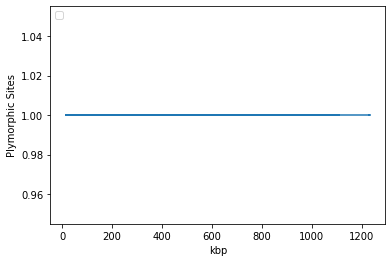

In [49]:
import matplotlib.pyplot as plt

y = vcf_count.select('count(POS)').collect()
x = vcf_count.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Plymorphic Sites')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()

### HAPLOTYPE DIVERSITY 

In [41]:
#try haplotype diversity instead 
vcf.show()

+------+-------+---------+----+-------+----+------+--------------------+-----------+--------------+--------------+------------+
|#CHROM|    POS|       ID| REF|    ALT|QUAL|FILTER|                INFO|     FORMAT|       NA00001|       NA00002|     NA00003|
+------+-------+---------+----+-------+----+------+--------------------+-----------+--------------+--------------+------------+
|    20|  14370|rs6054257|   G|      A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ|0|0:48:1:51,51|1|0:48:8:51,51|1/1:43:5:.,.|
|    20|  17330|        .|   T|      A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ|0|0:49:3:58,50|  0|1:3:5:65,3|    0/0:41:3|
|    20|1110696|rs6040355|   A|    G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ|1|2:21:6:23,27|  2|1:2:0:18,2|    2/2:35:4|
|    20|1230237|        .|   T|      .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ|0|0:54:7:56,60|0|0:48:4:51,51|    0/0:61:2|
|    20|1234567|microsat1|GTCT|G,GTACT|  50|  PASS|      NS=3;DP=9;AA=G|   GT:GQ:DP|      0/1:35:4|     

Calculate haplotype diversity: 
1. relative frequency of each haplotype: Hf = Hj / N where Hj is number of times haplotype j occurs and N number of individuals/sequences in the dataset  
2. haplotype diversity: Hd = N/N-1 * (1 - sum(Hf^2)) (for each haplotype in the window) -> fråga nån som kan matte!!!!

todo: 
1. for rows with more than one alternative allel: split so one allel per row 
2. transform the genotype values to numeric 

In [80]:
from pyspark.sql.functions import split, explode

#split rows so that ecah row only has one alternative allel in ALT 
vcf_split = vcf.withColumn('ALT_SPLIT',explode(split('ALT',',')))
vcf_split.show()

+------+-------+---------+----+-------+----+------+--------------------+-----------+-------+-------+-------+----------+---------+
|#CHROM|    POS|       ID| REF|    ALT|QUAL|FILTER|                INFO|     FORMAT|NA00001|NA00002|NA00003|POS_BUCKET|ALT_SPLIT|
+------+-------+---------+----+-------+----+------+--------------------+-----------+-------+-------+-------+----------+---------+
|    20|  14370|rs6054257|   G|      A|  29|  PASS|NS=3;DP=14;AF=0.5...|GT:GQ:DP:HQ| [0, 0]| [1, 0]| [1, 1]|      14.0|        A|
|    20|  17330|        .|   T|      A|   3|   q10| NS=3;DP=11;AF=0.017|GT:GQ:DP:HQ| [0, 0]| [0, 1]| [0, 0]|      17.0|        A|
|    20|1110696|rs6040355|   A|    G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ| [1, 2]| [2, 1]| [2, 2]|    1110.0|        G|
|    20|1110696|rs6040355|   A|    G,T|  67|  PASS|NS=2;DP=10;AF=0.3...|GT:GQ:DP:HQ| [1, 2]| [2, 1]| [2, 2]|    1110.0|        T|
|    20|1230237|        .|   T|      .|  47|  PASS|     NS=3;DP=13;AA=T|GT:GQ:DP:HQ| [0, 0

In [81]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, struct
import re 

def index_allel(ALT, ALT_SPLIT):
    res = re.findall('[ATGC.]+', ALT)
    regex = re.compile(rf'^{ALT_SPLIT}$')
    idx = [i+1 for i, item in enumerate(res) if re.search(regex, item)]
    return idx[0]

index_allel_udf = udf(index_allel, StringType())

vcf_split = vcf_split.withColumn('INDEX_ALLEL', index_allel_udf('ALT', 'ALT_SPLIT'))

vcf_split.select('ALT', 'ALT_SPLIT', 'INDEX_ALLEL').show()

+-------+---------+-----------+
|    ALT|ALT_SPLIT|INDEX_ALLEL|
+-------+---------+-----------+
|      A|        A|          1|
|      A|        A|          1|
|    G,T|        G|          1|
|    G,T|        T|          2|
|      .|        .|          1|
|G,GTACT|        G|          1|
|G,GTACT|    GTACT|          2|
+-------+---------+-----------+



In [82]:
import re 
from pyspark.sql.functions import udf

#Get names of sample columns 
col = vcf.schema.names
col = [x for x in col if re.match("NA*", x)]

#function that gets GT (genotype) part of sample information 
def get_genotypes(sample):
    res = sample.split(':')[0]
    res = re.findall('[0-9]', res)
    return res 

#udf 
udf_get_genotypes = udf(get_genotypes, StringType())

#loop through samples 
for sample in col: 
    vcf_split = vcf_split.withColumn(sample, udf_get_genotypes(sample))
    
vcf_split.select('ALT', 'ALT_SPLIT', 'INDEX_ALLEL', 'NA00001', 'NA00002', 'NA00003').show()

+-------+---------+-----------+-------+-------+-------+
|    ALT|ALT_SPLIT|INDEX_ALLEL|NA00001|NA00002|NA00003|
+-------+---------+-----------+-------+-------+-------+
|      A|        A|          1| [0, 0]| [1, 0]| [1, 1]|
|      A|        A|          1| [0, 0]| [0, 1]| [0, 0]|
|    G,T|        G|          1| [1, 2]| [2, 1]| [2, 2]|
|    G,T|        T|          2| [1, 2]| [2, 1]| [2, 2]|
|      .|        .|          1| [0, 0]| [0, 0]| [0, 0]|
|G,GTACT|        G|          1| [0, 1]| [0, 2]| [1, 1]|
|G,GTACT|    GTACT|          2| [0, 1]| [0, 2]| [1, 1]|
+-------+---------+-----------+-------+-------+-------+



In [94]:
#count number of times each allel occurs 
def count_allel(sample, INDEX_ALLEL):
    return sample.count(INDEX_ALLEL)
    
count_allel_udf = udf(count_allel, StringType())

for sample in col:
    vcf_split = vcf_split.withColumn(sample, count_allel_udf(sample, 'INDEX_ALLEL'))

vcf_split.select('ALT', 'ALT_SPLIT', 'INDEX_ALLEL', 'NA00001', 'NA00002', 'NA00003').show()


+-------+---------+-----------+-------+-------+-------+
|    ALT|ALT_SPLIT|INDEX_ALLEL|NA00001|NA00002|NA00003|
+-------+---------+-----------+-------+-------+-------+
|      A|        A|          1|      0|      1|      2|
|      A|        A|          1|      0|      1|      0|
|    G,T|        G|          1|      1|      1|      0|
|    G,T|        T|          2|      1|      1|      2|
|      .|        .|          1|      0|      0|      0|
|G,GTACT|        G|          1|      1|      0|      2|
|G,GTACT|    GTACT|          2|      0|      1|      0|
+-------+---------+-----------+-------+-------+-------+



In [122]:
#Calculate relative frequency 
Hf = vcf_split.withColumn('Hf', sum(vcf_split[sample] for sample in col)/(len(col)*2))
Hf.select('Hf').show()

+-------------------+
|                 Hf|
+-------------------+
|                0.5|
|0.16666666666666666|
| 0.3333333333333333|
| 0.6666666666666666|
|                0.0|
|                0.5|
|0.16666666666666666|
+-------------------+



In [123]:
#Calculate Hf^2
Hf = Hf.withColumn('Hf2', Hf['Hf']**2)
Hf.select('Hf', 'Hf2').show()

+-------------------+--------------------+
|                 Hf|                 Hf2|
+-------------------+--------------------+
|                0.5|                0.25|
|0.16666666666666666|0.027777777777777776|
| 0.3333333333333333|  0.1111111111111111|
| 0.6666666666666666|  0.4444444444444444|
|                0.0|                 0.0|
|                0.5|                0.25|
|0.16666666666666666|0.027777777777777776|
+-------------------+--------------------+



In [129]:
from pyspark.sql.types import FloatType

#Group by bucket 
Hd = Hf.groupBy('POS_BUCKET')\
        .agg({'Hf2':'sum'})\
        .orderBy('POS_BUCKET')
        
def cal_Hd(sum_Hf2):
    #fix this not hard coded 
    N = 6
    return (N/(N-1)) * 1 - sum_Hf2

cal_hd_udf = udf(cal_Hd, FloatType())

Hd = Hd.withColumn('Hd', cal_hd_udf('sum(Hf2)'))
Hd.show()

+----------+--------------------+----------+
|POS_BUCKET|            sum(Hf2)|        Hd|
+----------+--------------------+----------+
|      14.0|                0.25|      0.95|
|      17.0|0.027777777777777776| 1.1722223|
|    1110.0|  0.5555555555555556|0.64444447|
|    1230.0|                 0.0|       1.2|
|    1234.0|  0.2777777777777778| 0.9222222|
+----------+--------------------+----------+



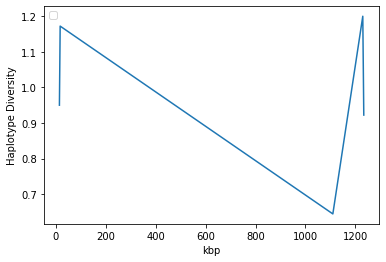

In [130]:
#plot
import matplotlib.pyplot as plt

y = Hd.select('Hd').collect()
x = Hd.select('POS_BUCKET').collect()

plt.plot(x, y)

plt.ylabel('Haplotype Diversity')
plt.xlabel('kbp')
plt.title('')
plt.legend('', loc='upper left')

plt.show()